In [19]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

import os
import logger
from common import monitor

In [20]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [21]:
#USE_CUDA = torch.cuda.is_available()
#Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Replay Memory
-----------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need:

-  ``ReplayBuffer`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.
-  ``ReplayBuffer.buffer`` - a deque where each entry is a tuple containing (state, action, reward, next_state, done). ``state``, ``action``, and ``next_state`` are numpy arrays, while ``done`` is a bool

In [22]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0) #convert 2D torch tensor into 1D numpy variable
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        # unzip the entries in the buffer into the 5 separate variables
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        #return np.array(state), action, reward, np.array(next_state), done
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [23]:
logger.configure()
env_id = "CartPole-v0"
env = gym.make(env_id)
env    = monitor.Monitor(env, logger.get_dir())

Logging to /tmp/RL_Adventure-2019-02-08-10-15-46-153322


<h2>Epsilon greedy exploration</h2>

In [24]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

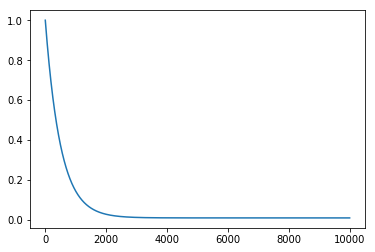

In [25]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Deep Q Network</h2>

In [26]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_hiddenNodes1):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], num_hiddenNodes1),
            nn.ReLU(),
            nn.Linear(num_hiddenNodes1, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)
            q_value = self.forward(state).detach()
            #action  = q_value.max(1)[1].data[0]
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [27]:
def save_variables(model_file):
    torch.save(model.state_dict(), model_file)

In [28]:
def load_variables(load_path):
    model.load_state_dict(torch.load(PATH))
    model.eval() #  to set dropout and batch normalization layers to evaluation mode before running inference

In [29]:
model = DQN(env.observation_space.shape[0], env.action_space.n, 128).to(device)
target_model = DQN(env.observation_space.shape[0], env.action_space.n, 128).to(device)
   
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

<h3>Synchronize current policy net and target net</h3>

In [30]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [31]:
update_target(model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [32]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    states = torch.tensor(state,dtype=torch.float32,device=device)
    next_states = torch.tensor(next_state,dtype=torch.float32,device=device)
    actions = torch.tensor(action,dtype=torch.long, device=device)
    rewards = torch.tensor(reward,dtype=torch.float32,device=device)  
    dones = torch.tensor(done,dtype=torch.float32,device=device)
    
    q_values      = model(states)
    next_q_values = target_model(next_states).detach()
    
    q_value          = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = rewards + gamma * next_q_value * (1 - dones)
    
    #loss = (q_value - expected_q_value).pow(2).mean().unsqueeze(0)
    loss = F.smooth_l1_loss(q_value, expected_q_value) # Huber loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [33]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

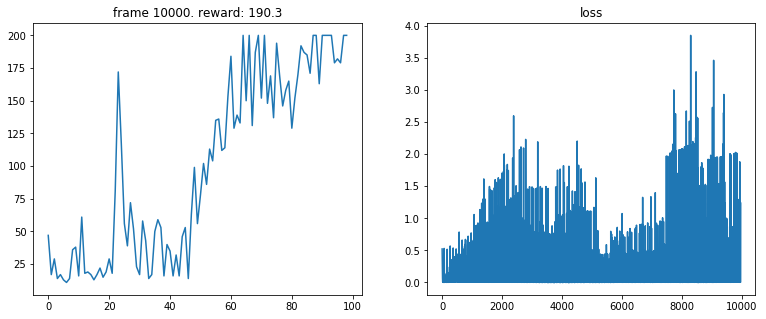

Saving model due to mean reward increase: 189.8 -> 190.3


In [34]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
num_episodes = 0
saved_mean_reward = None

target_network_update_freq = 100
train_freq = 1
checkpoint_freq = 1000

model_file = os.path.join(os.getcwd(), env_id[:10]+"model_test")

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
        mean_10ep_reward = round(np.mean(all_rewards[-11:-1]), 1)
        num_episodes = len(all_rewards)
        
    if len(replay_buffer) > batch_size and frame_idx % train_freq == 0:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % target_network_update_freq == 0:
        update_target(model, target_model)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if (frame_idx > batch_size and num_episodes > 10 and frame_idx % checkpoint_freq == 0):
        if saved_mean_reward is None or mean_10ep_reward > saved_mean_reward:
            logger.log("Saving model due to mean reward increase: {} -> {}".format(
                                   saved_mean_reward, mean_10ep_reward))
            save_variables(model_file)
            saved_mean_reward = mean_10ep_reward

<h1>Atari Environment</h1>

In [17]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
logger.configure()

Logging to /tmp/RL_Adventure-2019-02-07-23-16-41-829728


In [18]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = monitor.Monitor(env, logger.get_dir())
env    = wrap_deepmind(env, frame_stack = True)
env    = wrap_pytorch(env)

In [19]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state_   = torch.tensor(state,dtype=torch.float32,device=device).unsqueeze(0)
            q_value = self.forward(state_).detach()
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [20]:
model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
target_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
update_target(model, target_model)
print(device)
    
optimizer = optim.Adam(model.parameters(), lr=0.000025)

replay_initial = 50000
replay_buffer = ReplayBuffer(1000000)

cuda


In [21]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000
final_explr = int(2e5)

epsilon_by_frame = lambda frame_idx: max(epsilon_start - (epsilon_start - epsilon_final) * (frame_idx / final_explr), epsilon_final)

#epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

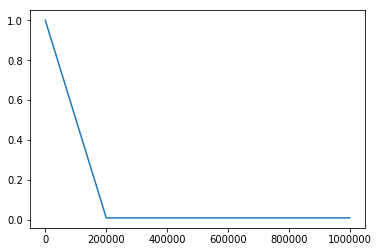

In [22]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

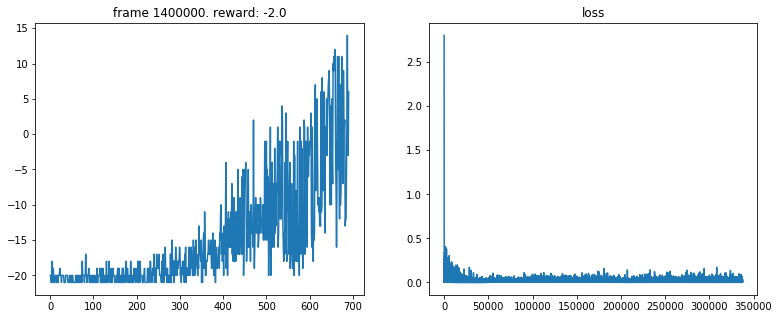

Saving model due to mean reward increase: -2.7 -> -2.4


In [23]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
num_episodes = 0
saved_mean_reward = None

target_network_update_freq = 10000
train_freq = 4
print_freq = 100    # no. of episodes
checkpoint_freq = 10000
plot_freq = 10000

model_file = os.path.join(os.getcwd(), env_id[:10]+"model_test") # Save weights of NN in current directory as the file "model"

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
        mean_100ep_reward = round(np.mean(all_rewards[-101:-1]), 1)
        num_episodes = len(all_rewards)

        if len(all_rewards) % print_freq == 0:
            logger.record_tabular("steps", frame_idx)               # record_tabular = logkv
            logger.record_tabular("episodes", len(all_rewards))
            logger.record_tabular("mean 100 episode reward", mean_100ep_reward)
            logger.record_tabular("% time spent exploring", epsilon)
            logger.dump_tabular()  
        
    if len(replay_buffer) > replay_initial and frame_idx % train_freq == 0:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
    
    if frame_idx % target_network_update_freq == 0:
        update_target(model, target_model)    
        
    if frame_idx % plot_freq == 0:
        plot(frame_idx, all_rewards, losses)
        
    if (frame_idx > batch_size and num_episodes > 10 and frame_idx % checkpoint_freq == 0):
        if saved_mean_reward is None or mean_100ep_reward > saved_mean_reward:
            logger.log("Saving model due to mean reward increase: {} -> {}".format(
                                   saved_mean_reward, mean_100ep_reward))
            save_variables(model_file)
            saved_mean_reward = mean_100ep_reward